# Clasificador de piezas de arte

- Curso: INFO257 Inteligencia Artificial
- Profesor: Pablo Huijse 
- Consultas por slack o correo: phuijse at inf dot uach dot cl 

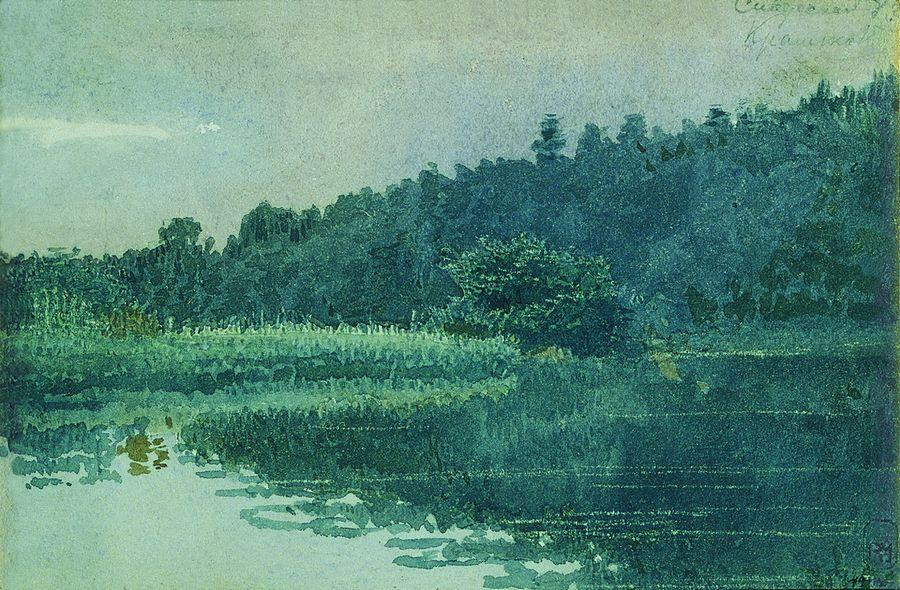

["Siverskaya" del pintor Ivan Kramskoy,1982](https://www.wikiart.org/en/ivan-kramskoy/siverskaya-1883)

## Objetivo

> El objetivo de esta actividad es entrenar y evaluar una red neuronal profunda para clasificar automáticamente el estilo de una pintura. Usted entrenará este modelo usando un conjunto de 1,000 imágenes de 10 estilos distintos. Las imágenes fueron obtenidas de la enciclopedia de arte visual [WikiArt.org](https://www.wikiart.org/)



## Datos

Para resolver esta tarea se le ha proporcionado una base de datos que puede descargar en el siguiente enlace: 

> https://drive.google.com/file/d/14JO2UMUnNYCyDGr_8qHVA_s4zn0d33pT/view?usp=sharing

La base de datos ya está separada en conjuntos de entrenamiento y prueba según los archivos de texto plano incluidos `train.txt` y `test.txt`, respectivamente. Se recomienda crear un script de Python que lea estos archivos y organice las imágenes tal que sean compatibles con [`torchvision.datasets.ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder)

Las etiquetas se entregan como un entero de 0 a 9 cuyo significado es

- 0: [Art Nouveau o Modernismo](https://es.wikipedia.org/wiki/Modernismo_(arte))
- 1: [Barroco](https://es.wikipedia.org/wiki/Barroco)
- 2: [Expresionismo](https://es.wikipedia.org/wiki/Expresionismo)
- 3: [Impresionismo](https://es.wikipedia.org/wiki/Impresionismo)
- 4: [Neoclasicismo](https://es.wikipedia.org/wiki/Neoclasicismo)
- 5: [Posimpresionismoo](https://es.wikipedia.org/wiki/Posimpresionismo)
- 6: [Realismo](https://es.wikipedia.org/wiki/Realismo_art%C3%ADstico)
- 7: [Romanticismo](https://es.wikipedia.org/wiki/Romanticismo)
- 8: [Surrealismo](https://es.wikipedia.org/wiki/Surrealismo)
- 9: [Symbolism](https://es.wikipedia.org/wiki/Simbolismo)

## Instrucciones generales

- Se trabajará en grupos de dos personas. Informe los integrantes del grupo a su profesor a la brevedad
- El grupo debe crear un repositorio privado en www.github.com 
- Invite a su profesor como colaborador (usuario: phuijse)
- No suba los datos al repositorio, suba sólo sus códigos fuente y reportes de resultado
- Se evaluará en base al último *commit* del Lunes 11 de Enero de 2021
- [Sean honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish)


## Instrucciones específicas

En esta tarea usted debe seleccionar, entrenar y evaluar un modelo profundo para resolver el problema anteriormente presentado

1. Seleccione un modelo del módulo [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) y descríbalo en detalle. Se recomienda revisar las publicaciones asociadas
1. Use el modelo  seleccionado pre-entrenado en ImageNet como extractor de características
1. Utilice un esquema de tipo *transfer learning* para entrenar el modelo. Usted debe diseñar una nueva cabeza clasificadora para el modelo seleccionado y decidir cuales/cuantas capas congelar. 

Indicaciones
- Separe el conjunto de entrenamiento en dos subconjuntos para ajustar los parámetros y calibrar los hiperparámetros, respectivamente. Proponga e implemente estrategias para prevenir el sobreajuste del modelo
- Evalue la capacidad de generalización de su modelo final midiendo su rendimiento en el conjunto de prueba. Presente sus resultados usando curvas de aprendizaje, matrices de confusión, *accuraccy* y *f1-score*. 
- Documente el proceso iterativo que lo llevó a decidir su arquitectura final. Justifique sus decisiones de función de costo, optimizador, arquitectura, regularización, etc. Analice sus resultados, inspeccione los errores del modelo. Comente, discuta y concluya

## Desarrollo

**Integrantes**:
- Reinaldo Bustamante
- María Belén Barrientos

### Modelo

Para elegir el modelo a implementar, analizamos la tabla presentada en la documentación de torchvision (https://pytorch.org/docs/stable/torchvision/models.html), la cual nos muestra las tasas de error de cada modelo por ImageNet. A continuación podemos ver cuáles son los tres modelos que tienen menor tasa:

|Network|Top-1 Error|Top-5 Error|
|---|---|---|
|ResNeXt-101-32x8d|20.69|5.47|
|Wide ResNet-101-2|21.16|5.72|
|Wide ResNet-50-2|21.49|5.91|

Basados en esta tabla, decidimos usar el modelo ResNeXt-101-32x8d, ya que tiene la menor tasa de error.

#### Descripción

ResNeXt está inspirado en los modelos VGG y ResNet y adopta la estrategia de repetición de capas mientras explota la estrategia de separar, transformar y fusionar. Esta arquitectura está compuesta por un stack de bloques residuales que tienen la misma topología y están sujetos a dos reglas inspiradas en los modelos antes mencionados. En primer lugar, si se producen mapas espaciales del mismo tamaño, los bloques comparten los hiperparámetros (ancho y tamaños de los filtros), segundo, cada vez que el mapa espacial es reducido por un factor de 2, el ancho de los bloques se multiplica por un factor de 2. Esta última regla asegura que la complejidad computacional es aproximadamente igual para todos los bloques.

Con estas reglas en mente se construyó el diseño de las redes que vemos a continuación.
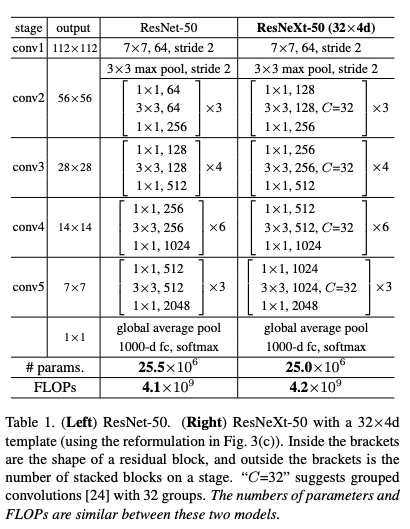

ResNeXt reemplaza la operación elemental de una neurona por una función más genérica, la cual se puede considerar una red por si misma. De esta forma, las transformaciones agregadas quedan representadas con la siguiente ecuación,

$$ \digamma(x) = \sum_{i=1}^{C}\tau_{i}(x)$$ 
<center><i><small>Ecuación (1)</small></i></center>

donde $\tau_{i}(x)$ puede ser una función arbitraria, y análogamente a una neurona simple, $\tau_{i}(x)$ debe proyectar $x$ en un embedding y transformarla.  

$C$ corresponde al tamaño del set de transformaciones a agregar (**Cardinalidad**), la cardinalidad es una dimensión esencial que puede ser más efectiva que las dimensiones del ancho y profundidad.

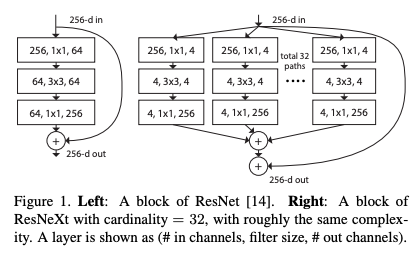

En la Figura 1, se muestra que la arquitectura tiene forma de cuello de botella, la cual está establecida por la transformación $\tau_{i}$, en este caso la primera capa de 1x1 en cada $\tau_{i}$ produce el embedding de baja dimensionalidad.  

Además la transformación agregada (Ecuación 1), sirve como la función residual en el esquema derecho de la figura 1, donde $y$ es la salida

$$y = x + \sum_{i=1}^{C}\tau_{i}(x)$$
<center><i><small>(2)</small></i></center>

En la Figura 3(b), podemos ver la relación con el bloque *Inception-ResNet* al cual se parece, sin embargo, la diferencia se encuentra en que la topología es la misma para los múltiples caminos, por lo que el módulo de ResNeXt requiere un mínimo esfuerzo extra en el diseño de cada camino.

Figura3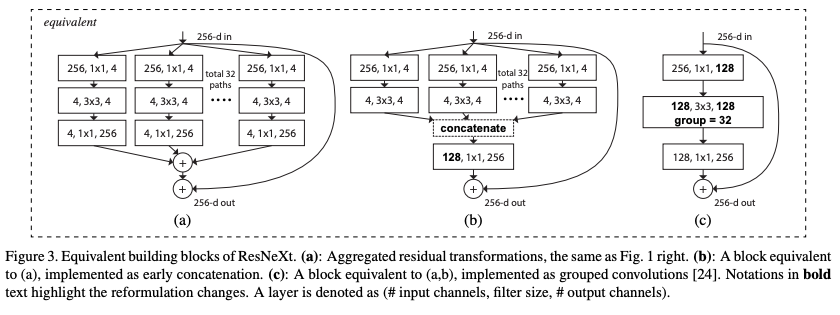

En la Figura 3(c) se ve la reformulación del módulo usando la notación de convolución agrupada. Todos los embeddings de baja dimesionalidad pueden ser por una única y más ancha capa. La división está hecha esencialmente por la capa convolucional agrupada cuando divide sus canales de entrada en grupos. Esta capa, realiza 32 grupos de convoluciones donde los canales de entrada y salida son de 4 dimensiones. Así, el bloque de la Figura 3(c) se parece al cuello de botella original del bloque residual de la Figura 1(izquierda), con la diferencia de que este es un módulo más ancho y escasamente conectado.

Los experimentos registrados en el paper que presenta los modelos ResNeXt (https://arxiv.org/pdf/1611.05431.pdf), muestran que la precisión de estos modelos mejora la de los ResNet cuando se mantiene la complejidad de este y el número de parámetros.

### Implementación